In [47]:
# Various accretion parameters of Bondi-Hoyle-Lyttleton (BHL) 
# accretion model used in reference papaer M. Ricotti et al. 
# https://arxiv.org/abs/0709.0524 and Park Ricotti Model (PR)
# accretion model as per F. Scarcella et al. 2020, 
# https://arxiv.org/abs/2012.10421 . 


# Here, the value of the speed of sound in the ioinized region of 
# PR Model is chosen as c_s,in = 25 c_s. c_s,in is the free parameter 
# of PR accretion Model.


# The values of v_pbh, c_s and v_eff are used as per 
# M. Ricotti et al. 2007 https://arxiv.org/abs/0709.0524
 

# Here,  v_eff = v_eff,A as mentioned in
# M. Ricotti et al. 2007 https://arxiv.org/abs/0709.0524

from scipy.integrate import quad
import numpy as np
from scipy.integrate import odeint
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.integrate as spi
from scipy.integrate import solve_ivp
from scipy import integrate
import matplotlib.ticker
from scipy.optimize import bisect, brentq, newton, root
from PRaccretion import*
import math
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


def c_s(z): # in units of pc/yr
    return c_s_Serpico(z)

def v_pbh_linear_regime(z): # in units of pc/yr
    return  v_L_Serpico(z)

def v_pbh_nonlinear_regime(z): # in units of pc/yr
    def M_2σ(z):
        return 8.8e12 * np.exp(-1.8 * (1+z))
    return 17 * ((M_2σ(z) * 1e-8)**(1/3)) * (((1+z)/10)**(1/2)) * 1e3 * (yr/pc)

def v_eff_linear_regime(z): # in units of pc/yr
    return v_eff_Serpico(z)

def v_eff_nonlinear_regime(z): # in units of pc/yr
    return 800 * np.exp(-0.6 * (1+z)) *  (((1+z)/10)**(1/2)) * 1e3 * (yr/pc)


#PBH's velocity with both linear (z>10) and non-linear(z<=10) corrections included
def v_pbh(z): # in units of pc/yr
    if z > 10:
        return v_pbh_linear_regime(z)
    else:
        return v_pbh_nonlinear_regime(z)
    
    
# Effective velocity with both linear (z>10) and non-linear(z<=10) corrections included
def v_eff(z): # in units of pc/yr
    if z > 10:
        return v_eff_linear_regime(z)
    else:
        return v_eff_nonlinear_regime(z)


def x_e(z):
    if z < z_rec:
        return e_fraction
    else:
        return 1
    
    
# BHL accretion Model around isolated PBHs 
def r_B_pbh(z, m):
    return (G * m)/(v_eff(z)**2)

def β_cap_pbh(z, m): # Here, β_pbh = β(m_pbh)
    return 1e-4 * m * (((1+z)/1000)**(3/2)) * (((5.74e3 * (yr/pc))/v_eff(z))**3) * (0.257 + 1.45 * (x_e(z)/0.01) * (((1+z)/1000)**(5/2)))

def λ_pbh(z, m):
    def x_cr(z, m):
        return (-1 + np.sqrt(1 + β_cap_pbh(z, m)))/β_cap_pbh(z, m) 
    return np.exp((9/2)/(3 + β_cap_pbh(z, m)**(0.75))) * (x_cr(z, m)**2)

def M_dot_pbh_BHL(z, m):
    return 4 * np.pi * λ_pbh(z, m) *  ρ(z) * v_eff(z) * (r_B_pbh(z, m)**2)

def m_dot_pbh_BHL(z, m):
    return M_dot_pbh_BHL(z, m)/M_dot_Edd(z, m) 

def M_dot_pbh_BHL_by_dz(z, m):
    return M_dot_pbh_BHL(z, m) * (dt_dz(z))




# BHL accretion Model in the presence of DM halos around isolated PBHs  
def r_ta(z, m):
    if DM_profile94 == True:
        return r_ta_Jangra(z, m)
    else:
        return r_ta_kavanagh(z, m)

def M_halo(z, m): # Mass of the DM halo at turn around radius r_ta.
    if DM_profile94 == True:
        return M_halo_Jangra(z, m)
    else:
        return M_halo_Kavanagh(z, m)


def r_B_halo(z, m):
    return (G * M_halo(z, m))/(v_eff(z)**2)


def r_B_eff(z, m):
    if r_ta(z, m) <= r_B_halo(z, m):
        r_B_eff_var =  (r_B_halo(z, m) + r_B_pbh(z, m))
    else:
        def a(z, m):
             return  (r_B_halo(z, m)/(1-p)) * (1/(r_ta(z, m)**p))
        def b(z, m):
            return 1  +   (p/(1-p)) * (r_B_halo(z, m)/r_ta(z, m))
        def c(z, m):
            return   r_B_pbh(z, m)
        #For, x = r_B,eff
        x_upper_limit = r_B_pbh(z, m) + r_B_halo(z, m)
        x_lower_limit = r_B_pbh(z, m)
        x0 = x_lower_limit
        def f(x):
            return ((a(z, m) * (x**p)) - b(z, m)*x + c(z, m))
       
        roots = newton(f, x0, tol=1e-7, maxiter=80)
        #roots = optimize.newton(lambda x: (a(z, m) * (x**p)) - b(z, m)*x + c(z, m), x_upper_limit)
        r_B_eff_var = roots
    return r_B_eff_var    
        

def β_cap_halo(z, m): # Here, β_halo = β(m_pbh + m_halo)
    return 1e-4 * (m + M_halo(z, m)) * (((1+z)/1000)**(3/2)) * (((5.74e3 * (yr/pc))/v_eff(z))**3) * (0.257 + 1.45 * (x_e(z)/0.01) * (((1+z)/1000)**(5/2)))

def λ_halo(z, m):
    def x_cr(z, m):
        return (-1 + np.sqrt(1 + β_cap_halo(z, m)))/β_cap_halo(z, m) 
    return np.exp((9/2)/(3 + β_cap_halo(z, m)**(0.75))) * (x_cr(z, m)**2)


def M_dot_halo_BHL(z, m):
    return 4 * np.pi * λ_halo(z, m) * ρ(z) * v_eff(z) * (r_B_eff(z, m)**(2))

def m_dot_halo_BHL(z, m):
    return M_dot_halo_BHL(z, m)/M_dot_Edd(z, m) 

def M_dot_halo_BHL_by_dz(z, m):
    return M_dot_halo_BHL(z, m) * (dt_dz(z))





# Definition of various parameters in the ionized region of
# PR accretion Model of F. Scarcella et al. https://arxiv.org/abs/2012.10421.
# Definition of various parameters in the ionized region of
# PR accretion Model of F. Scarcella et al. https://arxiv.org/abs/2012.10421.


# PR accretion Model around isolated PBHs 
free_parameter = 25
def c_s_in(z):
    return free_parameter * c_s(z)
def v_R(z):
    return  2 * c_s_in(z)
def v_D(z):
    return  (c_s(z)**2)/(2 * c_s_in(z))
def Δ(z):
    return (((v_pbh(z)**2) + (c_s(z)**2))**2) - (4 * (v_pbh(z)**2) * (c_s_in(z)**2)) 
def ρ_in_plus(z):
    return  ρ(z) * (((v_pbh(z)**2) + (c_s(z)**2) + np.sqrt(Δ(z)))/(2 * (c_s_in(z)**2)))
def ρ_in_minus(z):
    return ρ(z) * (((v_pbh(z)**2) + (c_s(z)**2) - np.sqrt(Δ(z)))/(2 * (c_s_in(z)**2)))
def ρ_in_0(z):
    return ρ(z) * (((v_pbh(z)**2) + (c_s(z)**2))/(2 * (c_s_in(z)**2)))
def ρ_in(z):
    if v_pbh(z) <= v_D(z):
        return ρ_in_plus(z)
    elif v_D(z) < v_pbh(z) < v_R(z):
        return ρ_in_0(z)
    else:
        return ρ_in_minus(z)

def v_in(z):
    if v_pbh(z) <= v_D(z):
        return (ρ(z)/ρ_in(z)) * v_pbh(z)
    elif v_D(z) < v_pbh(z) < v_R(z):
        return c_s_in(z)
    else:
        return (ρ(z)/ρ_in(z)) * v_pbh(z)

def v_eff_in(z):
    return np.sqrt((v_in(z)**2) + (c_s_in(z)**2))

def r_B_in(z, m):
    return (G * m)/(v_eff_in(z)**2)

def M_dot_pbh_PR(z, m):
    return 4 * np.pi  *  ρ_in(z) * v_eff_in(z) * (r_B_in(z, m)**2)

def m_dot_pbh_PR(z, m):
    return (M_dot_pbh_PR(z, m)/M_dot_Edd(z, m))

def M_dot_pbh_PR_by_dz(z, m):
    return M_dot_pbh_PR(z, m) * (dt_dz(z))



# PR accretion Model in the presence of DM halos around isolated PBHs  
def r_B_eff_in(z, m):
    def r_B_pbh_in(z, m):
        return (G * m)/(v_eff_in(z)**2)
    def r_B_halo_in(z, m):
        return (G * M_halo(z, m))/(v_eff_in(z)**2)
    if r_ta(z, m) <= r_B_halo_in(z, m):
        r_B_eff_in_var =  r_B_halo_in(z, m) + r_B_pbh_in(z, m)
    else:
        def a(z, m):
             return  (r_B_halo_in(z, m)/(1-p)) * (1/(r_ta(z, m)**p))
        def b(z, m):
            return 1  +   (p/(1-p)) * (r_B_halo_in(z, m)/r_ta(z, m))
        def c(z, m):
            return   r_B_pbh_in(z, m)
        #For, x = r_B,eff
        x_upper_limit = r_B_pbh_in(z, m) + r_B_halo_in(z, m)
        x_lower_limit = r_B_pbh_in(z, m)
        roots = newton(lambda x: (a(z, m) * (x**p)) - b(z, m)*x + c(z, m), x_upper_limit)
        r_B_eff_in_var = roots
    return r_B_eff_in_var    
         
        
def M_dot_halo_PR(z, m):
    return 4 * np.pi  *  ρ_in(z) * v_eff_in(z) * (r_B_eff_in(z, m)**2)

def m_dot_halo_PR(z, m):
    return (M_dot_halo_PR(z, m)/M_dot_Edd(z, m))

def M_dot_halo_PR_by_dz(z, m):
    return M_dot_halo_PR(z, m) * (dt_dz(z))

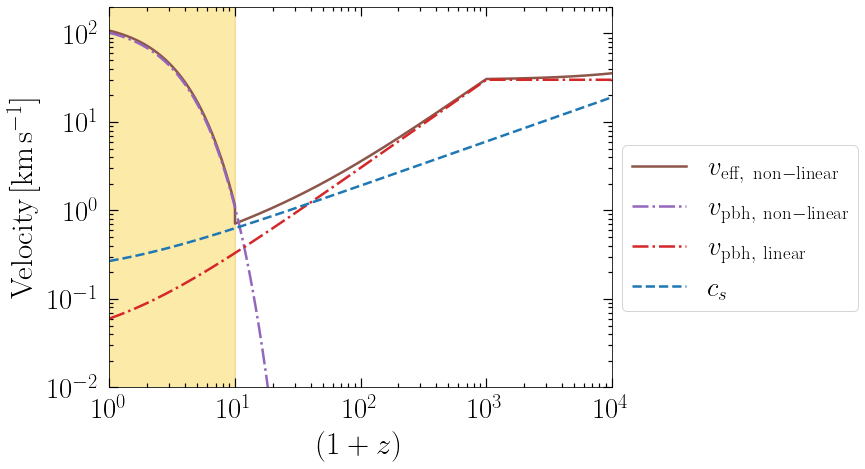

In [3]:
fig,ax = plt.subplots(1, figsize = (9, 7))
plt.rc('lines', linewidth = 2.5)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


z_array = np.geomspace(1, 1e4, 10000)
cs_array = np.zeros(len(z_array))
v_pbh_linear_array = np.zeros(len(z_array))
v_eff_nonlinear_array = np.zeros(len(z_array))
v_pbh_nonlinear_array = np.zeros(len(z_array))



for i, z in enumerate(z_array):
    cs_array[i] = c_s(z) * (pc/yr) * 1e-3 
    v_pbh_linear_array[i] = v_pbh_linear_regime(z) * (pc/yr) * 1e-3 
    v_pbh_nonlinear_array[i] = v_pbh_nonlinear_regime(z) * (pc/yr) * 1e-3 
    v_eff_nonlinear_array[i] = v_eff(z) * (pc/yr) * 1e-3 

ax.loglog(z_array, v_eff_nonlinear_array, 'C5')    
ax.loglog(z_array, v_pbh_nonlinear_array, 'C4', ls = '-.')  
ax.loglog(z_array, v_pbh_linear_array, 'C3', ls = '-.') 
ax.loglog(z_array, cs_array, 'C0', ls = '--')


plt.axvline(x = 10, color = '#6E705E', linewidth = 0.1)
plt.axvline(x = 1, color = '#6E705E', linewidth = 0.1)
plt.axvspan(1, 10, color='#FBDD70', alpha=0.6)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


plt.ylim(1e-2, 200)
plt.xlim(1, 1e4)


#v_\mathrm{pbh} \equiv v_\mathrm{rel,\, digitized}
plt.legend([r'$v_\mathrm{eff, \:\: non-linear}$', r'$v_\mathrm{pbh,\:\: non-linear}$', r'$v_\mathrm{pbh,\:\: linear}$',  
            '$c_{s}$'],
           title_fontsize = 12, loc = (1.02, 0.2), prop = {"size":27})



plt.ylabel(r"Velocity$\, \mathrm{[km \,s^{-1}}]$ ", fontsize = 31, labelpad = 8)
plt.xlabel(r"$(1+z)$", fontsize = 31, labelpad = 8)
plt.xticks(fontsize = 29)
plt.yticks(fontsize = 29)
#plt.title('M. Ricotti et al. 2007', fontsize = 31, pad = 9)
#plt.savefig('Ricotti_nonlinearvelocities.pdf', bbox_inches = 'tight')
plt.show()

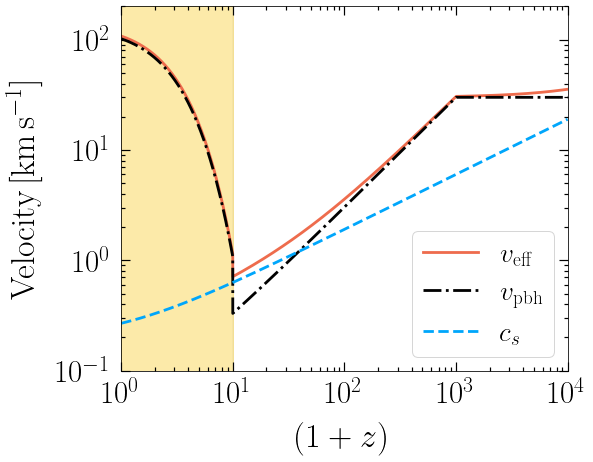

In [3]:
# Plot of v_eff, c_s(z) and v_pbh as per their definitions
# mentioned in Vivian Poulin & Pasquale D. Serpico et al. 2007 
# https://arxiv.org/abs/1707.04206. 



fig,ax = plt.subplots(1, figsize = (8, 6.7))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


z_array = np.geomspace(1, 1e4, 10000)
cs_array = np.zeros(len(z_array))
v_eff_array = np.zeros(len(z_array))
v_pbh_array = np.zeros(len(z_array))



for i, z in enumerate(z_array):
    cs_array[i] = c_s(z) * (pc/yr) * 1e-3 
    v_eff_array[i] = v_eff(z) * (pc/yr) * 1e-3 
    v_pbh_array[i] = v_pbh(z) * (pc/yr) * 1e-3 
    
ax.loglog(z_array, v_eff_array, '#ee6c4d') 
ax.loglog(z_array, v_pbh_array, 'k', ls = '-.') 

ax.loglog(z_array, cs_array, '#00a6fb', ls = '--')


plt.axvline(x = 10, color = '#6E705E', linewidth = 0.1)
plt.axvline(x = 1, color = '#6E705E', linewidth = 0.1)
plt.axvspan(1, 10, color='#FBDD70', alpha=0.6)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


plt.ylim(0.1, 200)
plt.xlim(1, 1e4)

plt.legend([ r'$v_\mathrm{eff} $', r'$v_\mathrm{pbh} $','$c_{s}$'],
           title_fontsize = 18, loc = 'lower right', prop = {"size":27.5})



plt.ylabel(r"Velocity$\, \mathrm{[km \,s^{-1}}]$ ", fontsize = 34, labelpad = 13)
plt.xlabel(r"$\left(1+z\right)$", fontsize = 34, labelpad = 13)
plt.xticks(fontsize = 31)
plt.yticks(fontsize = 31)
plt.savefig('velocities.pdf', bbox_inches = 'tight')
plt.show()

In [4]:
# Calculations of the accretion parameters and accretion rate 
# as per the DM density profile of ρ(r) ∝ r^{-9/4}.

DM_profile94 = True
alpha = 9/4
p = 3 - alpha

In [ ]:
# Calculations for PBHs with and without DM halos as per
# BHL Model

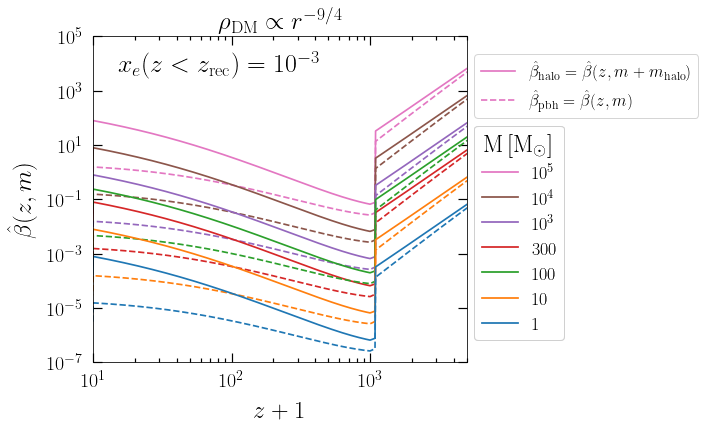

In [4]:
# Plots of β-parameter with and without the presence of
# DM halos with the fact that β_pbh = β(m_pbh) and
# β_halo = β(m_pbh + m_halo)

# Here, the electron fraction of the accreted gas after recombination is 
# considered as x_e = 1e-3.



colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1e5, 1e4, 1e3, 1e2, 300, 10, 1])
z_array = np.geomspace(1, 1e4, 1000)
β_pbh_array = np.zeros(len(z_array))
β_halo_array = np.zeros(len(z_array))

e_fraction = 1e-3


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        β_pbh_array[i] = β_cap_pbh(z, m)
        β_halo_array[i] = β_cap_halo(z, m)
    ax.loglog(z_array, β_halo_array, color = color)
    ax.loglog(z_array, β_pbh_array, color = color, ls = '--')

    

plt.text(15, 5000, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(r'$\hat \beta(z, m)$', fontsize = 25, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [r"$\hat \beta_\mathrm{halo} = \hat \beta(z, m + m_\mathrm{halo})$", r"$\hat \beta_\mathrm{pbh} = \hat \beta(z, m)$"],
        title_fontsize = 20, loc = (1.02, 0.75), prop = {"size":17})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 24, loc = (1.02, 0.07), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.xlim(10, 5000)
plt.ylim(1e-7, 1e5)
plt.title(r'$\rho_\mathrm{DM} \propto r^{-9/4}$', fontsize = 25, pad = 8)
plt.savefig('βvsz_xe1e-3_halo.pdf', bbox_inches = 'tight')
plt.show()

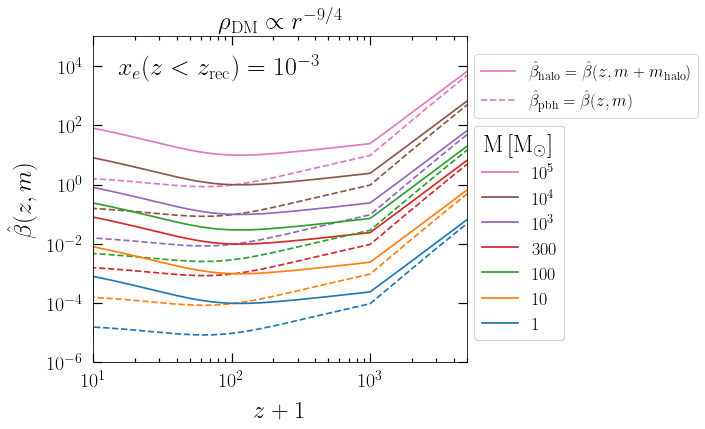

In [5]:
# Plots of β-parameter with and without the presence of
# DM halos with the fact that β_pbh = β(m_pbh) and
# β_halo = β(m_pbh + m_halo)

# Here, the electron fraction of the accreted gas after recombination is 
# considered as x_e = 1.


colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1e5, 1e4, 1e3, 1e2, 300, 10, 1])
z_array = np.geomspace(1, 1e4, 1000)
β_pbh_array = np.zeros(len(z_array))
β_halo_array = np.zeros(len(z_array))

e_fraction = 1


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        β_pbh_array[i] = β_cap_pbh(z, m)
        β_halo_array[i] = β_cap_halo(z, m)
    ax.loglog(z_array, β_halo_array, color = color)
    ax.loglog(z_array, β_pbh_array, color = color, ls = '--')

    

plt.text(15, 5000, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(r'$\hat \beta(z, m)$', fontsize = 25, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [r"$\hat \beta_\mathrm{halo} = \hat \beta(z, m + m_\mathrm{halo})$", r"$\hat \beta_\mathrm{pbh} = \hat \beta(z, m)$"],
        title_fontsize = 20, loc = (1.02, 0.75), prop = {"size":17})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 24, loc = (1.02, 0.07), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.xlim(10, 5000)
plt.ylim(1e-6, 1e5)
plt.title(r'$\rho_\mathrm{DM} \propto r^{-9/4}$', fontsize = 25, pad = 8)
plt.savefig('βvsz_xe1_halo.pdf', bbox_inches = 'tight')
plt.show()

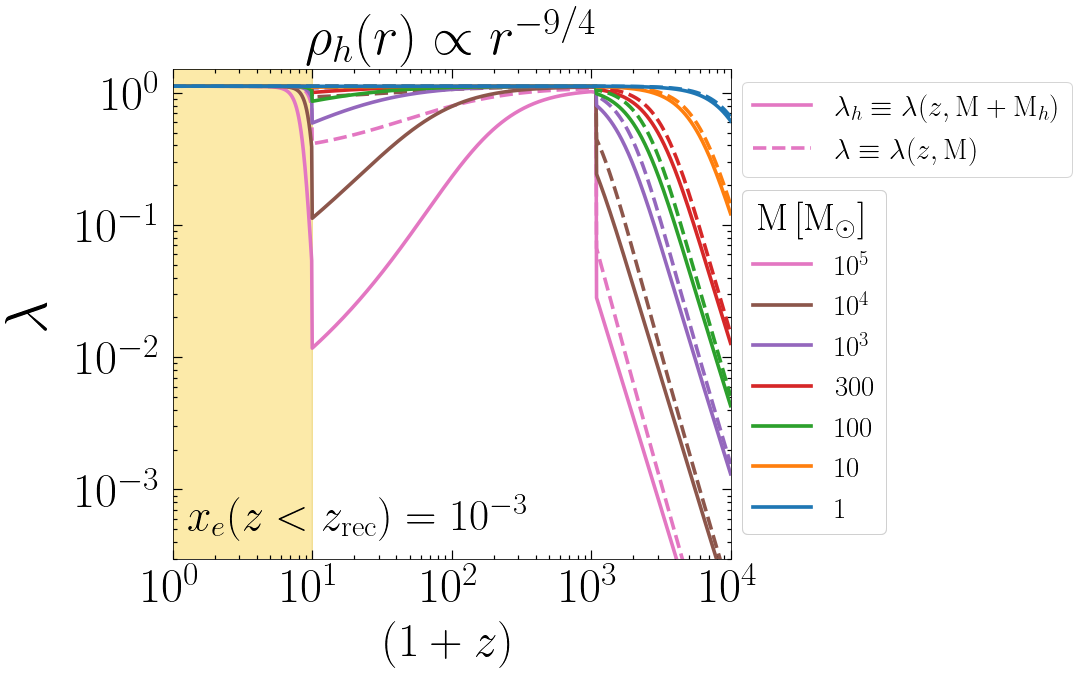

In [17]:
# Plots of β-parameter with and without the presence of
# DM halos with the fact that λ_pbh = λ(m_pbh) and
# λ_halo = λ(m_pbh + m_halo)

# Here, the electron fraction of the accreted gas after recombination is 
# considered as x_e = 1e-3.



colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (10, 9))
plt.rc('lines', linewidth = 3.6)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1e5, 1e4, 1e3, 1e2, 300, 10, 1])
z_array = np.geomspace(1, 1e4, 1000)
λ_pbh_array = np.zeros(len(z_array))
λ_halo_array = np.zeros(len(z_array))


e_fraction = 1e-3


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        λ_pbh_array[i] = λ_pbh(z, m)
        λ_halo_array[i] = λ_halo(z, m)
    ax.loglog(z_array, λ_halo_array, color = color)
    ax.loglog(z_array, λ_pbh_array, color = color, ls = '--')
    

    
plt.xlim(1, 1e4)
plt.ylim(3e-4, 1.5)
plt.text(1.3, 5e-4, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 44)
plt.xlabel(r'$\left(1+z\right)$',  fontsize = 47, labelpad = 10)
plt.ylabel(r'$\lambda$', fontsize = 59, labelpad = 18)
plt.xticks(fontsize = 48)
plt.yticks(fontsize = 48)


plt.axvline(x = 10, color = '#6E705E', linewidth = 0.1)
plt.axvline(x = 1, color = '#6E705E', linewidth = 0.1)
plt.axvspan(1, 10, color='#FBDD70', alpha=0.6)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [r"$\lambda_{h} \equiv \lambda(z, \mathrm{M} +  \mathrm{M}_{h})$", r"$\lambda \equiv \lambda(z,  \mathrm{M})$"],
        title_fontsize = 20, loc = (1.02, 0.78), prop = {"size":29})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 38, loc = (1.02, 0.05), prop = {"size":29})
ax.add_artist(legend1)
ax.add_artist(legend2)





plt.title(r'$\rho_{h}(r) \propto r^{-9/4}$', fontsize = 54, pad = 15)
plt.savefig('λvsz_xe1e-3_halo_nonlinear.pdf', bbox_inches = 'tight')
plt.show()

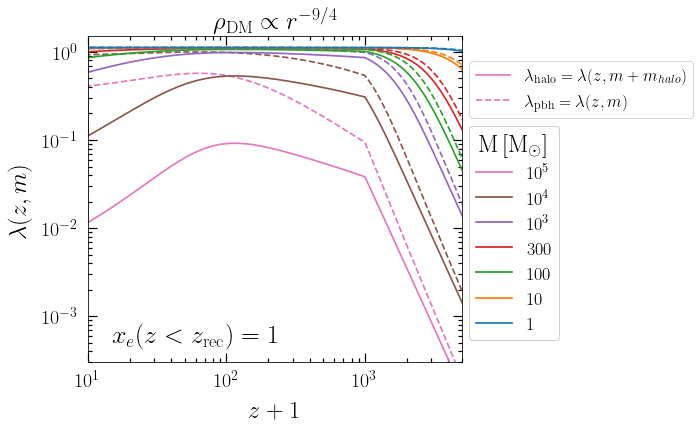

In [7]:
# Plots of β-parameter with and without the presence of
# DM halos with the fact that λ_pbh = λ(m_pbh) and
# λ_halo = λ(m_pbh + m_halo)

# Here, the electron fraction of the accreted gas after recombination is 
# considered as x_e = 1e-3.



colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1e5, 1e4, 1e3, 1e2, 300, 10, 1])
z_array = np.geomspace(1, 1e4, 1000)
λ_pbh_array = np.zeros(len(z_array))
λ_halo_array = np.zeros(len(z_array))


e_fraction = 1


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        λ_pbh_array[i] = λ_pbh(z, m)
        λ_halo_array[i] = λ_halo(z, m)
    ax.loglog(z_array, λ_halo_array, color = color)
    ax.loglog(z_array, λ_pbh_array, color = color, ls = '--')
    

    
plt.xlim(10, 5000)
plt.ylim(3e-4, 1.5)
plt.text(15, 5e-4, '$x_{e}(z < z_\mathrm{rec}) = 1$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 24.5, labelpad = 10)
plt.ylabel(r'$ \lambda(z, m)$', fontsize = 25, labelpad = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [r"$\lambda_\mathrm{halo} = \lambda(z, m + m_{halo})$", r"$\lambda_\mathrm{pbh} = \lambda(z, m)$"],
        title_fontsize = 20, loc = (1.02, 0.75), prop = {"size":17})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 24, loc = (1.02, 0.07), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)


plt.title(r'$\rho_\mathrm{DM} \propto r^{-9/4}$', fontsize = 25, pad = 8)
plt.savefig('λvsz_xe1_halo.pdf', bbox_inches = 'tight')
plt.show()

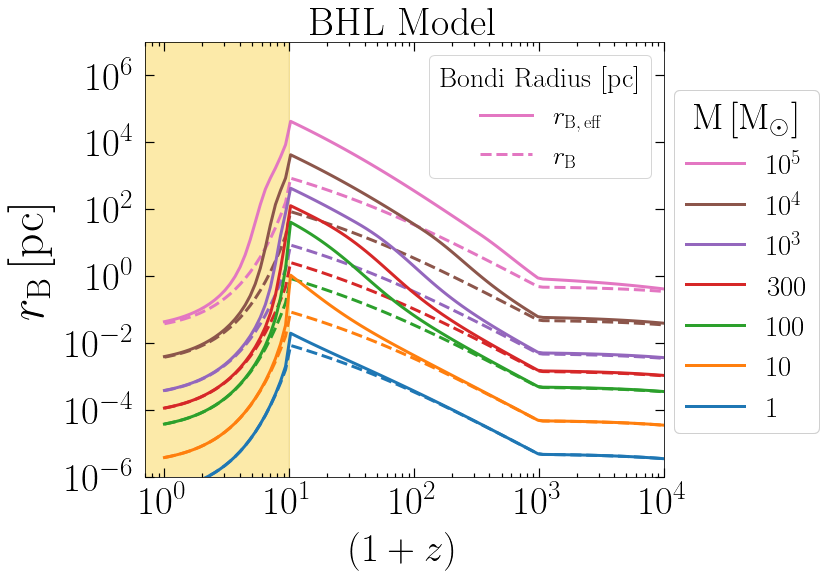

In [14]:
# Calculation of the effective Bondi Radius due to the presence of DM halo
# around the PBH

colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (9.3, 8))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_arr = np.geomspace(1, 1e4, 100)


r_B_pbh_arr = np.zeros(len(z_arr))
r_B_eff_arr = np.zeros(len(z_arr))




for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for j, z in enumerate(z_arr):
        r_B_pbh_arr[j] = r_B_pbh(z, m)
        r_B_eff_arr[j] = r_B_eff(z, m)
    ax.loglog(z_arr, r_B_eff_arr, color = color)
    ax.loglog(z_arr, r_B_pbh_arr, color = color, ls = '--')
    

    
#r_\mathrm{B} \equiv r_\mathrm{B, \,pbh}
ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)               
lines = ax.get_lines()             
legend1 = plt.legend([lines[i] for i in [0, 1]], ["$r_\mathrm{B, \,eff}$","$r_\mathrm{B}  $"], title = 'Bondi Radius $ \mathrm{[pc]}$',
        title_fontsize = 28, loc = 'upper right', prop = {"size":26})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 37, loc = (1.02, 0.10), prop = {"size":29})
ax.add_artist(legend1)
ax.add_artist(legend2)


plt.axvline(x = 10, color = '#6E705E', linewidth = 0.1)
plt.axvline(x = 0.7, color = '#6E705E', linewidth = 0.1)
plt.axvspan(0.7, 10, color='#FBDD70', alpha=0.6)


plt.ylim(1e-6, 1e7)
plt.xlim(0.7, 1e4)
plt.xlabel(r'$\left(1+z\right)$', fontsize = 39, labelpad = 10)
plt.ylabel(r"$r_\mathrm{B}\, \mathrm{[pc]}$ ", fontsize = 48, labelpad = 11)
plt.xticks(fontsize = 39)
plt.yticks(fontsize = 39)

#$\rho_{h}(r) \propto r^{-9/4}$
plt.title(r'BHL Model', fontsize = 40, pad = 4)
plt.savefig('r_B_eff_BHL_nonlinear.pdf', bbox_inches = 'tight')
plt.show()

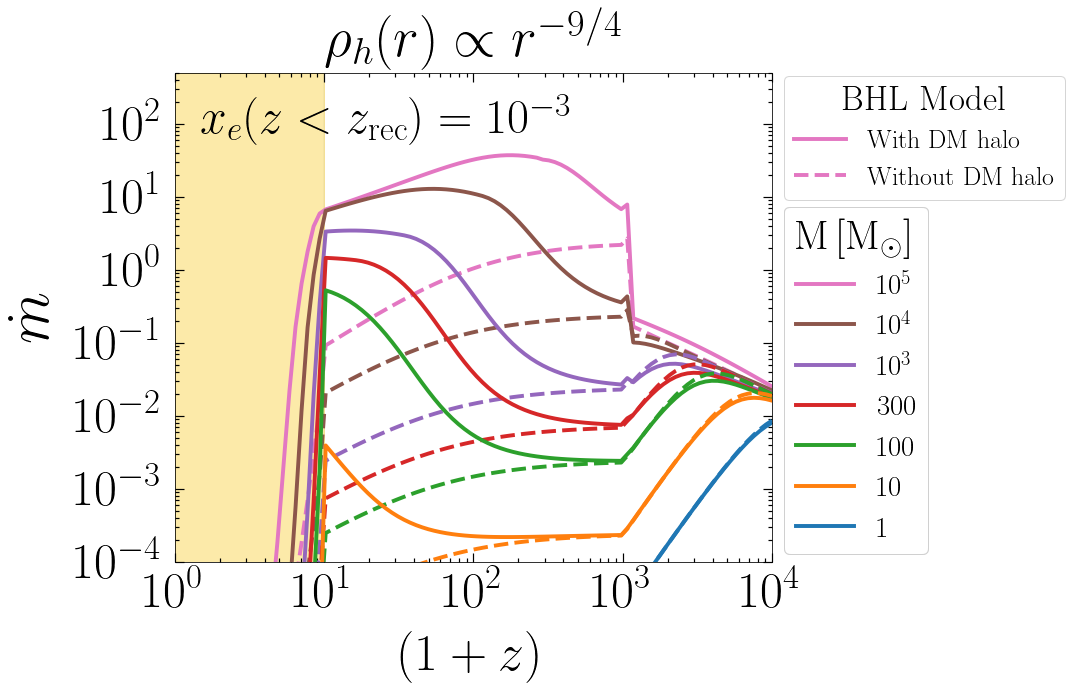

In [20]:
# Plots of m_dot in BHL model with and without the presence of
# DM halos for x_e = 1e-3.

colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (10.7, 9))
plt.rc('lines', linewidth = 3.9)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_pbh_arr = np.zeros(len(z_array))
m_dot_halo_arr = np.zeros(len(z_array))



e_fraction = 1e-3

for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_pbh_arr[i] = m_dot_pbh_BHL(z, m)
        m_dot_halo_arr[i] = m_dot_halo_BHL(z, m)
    ax.loglog(z_array, m_dot_halo_arr, color = color)
    ax.loglog(z_array, m_dot_pbh_arr, color = color, ls = '--')
    

plt.text(1.5, 76, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 48)
plt.xlabel(r'$\left(1+z\right)$',  fontsize = 52, labelpad = 14)
plt.ylabel(' $\dot m $', fontsize = 61, labelpad = 14)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)


plt.axvline(x = 10, color = '#6E705E', linewidth = 0.1)
plt.axvline(x = 1, color = '#6E705E', linewidth = 0.1)
plt.axvspan(1, 10, color='#FBDD70', alpha=0.6)


ax.tick_params(axis='x', pad = 10.9)
ax.tick_params(axis='y', pad = 10.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "With DM halo", "Without DM halo"], title = 'BHL Model',
        title_fontsize = 35, loc = (1.02, 0.74), prop = {"size":26})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 41, loc = (1.02, 0.017), prop = {"size":29})
ax.add_artist(legend1)
ax.add_artist(legend2)



plt.ylim(1e-4, 500)
plt.xlim(1, 1e4)
plt.title(r'$\rho_{h}(r) \propto r^{-9/4}$', fontsize = 55, pad = 17)
plt.savefig('m_dot_BHL_xe1e-3_nonlinear.pdf', bbox_inches = 'tight')
plt.show()

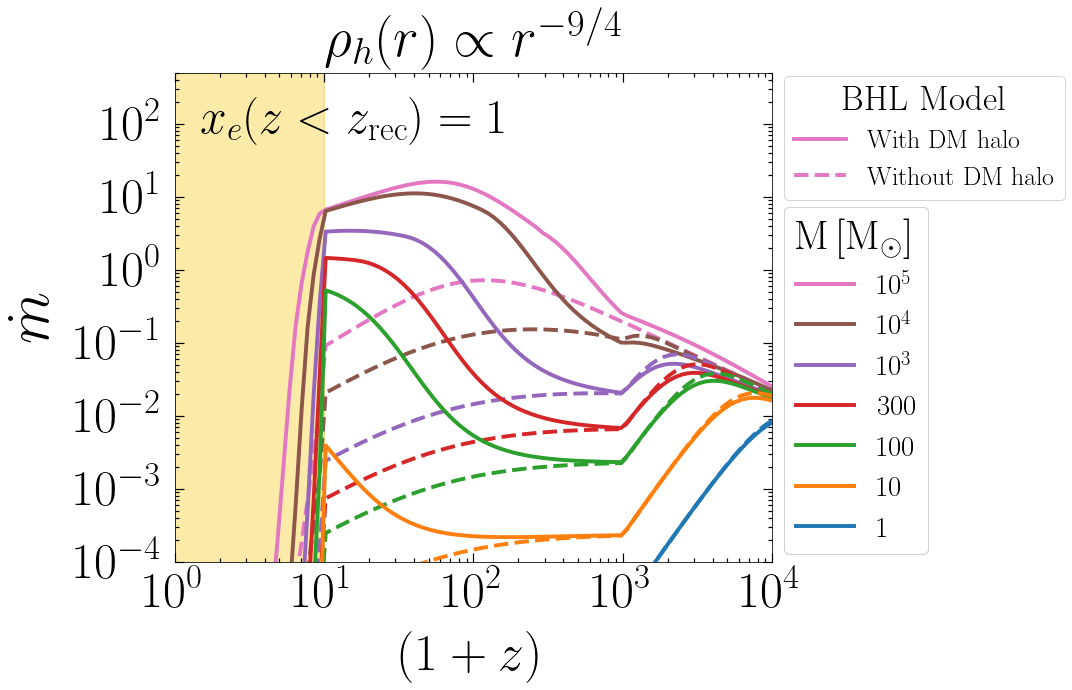

In [21]:
# Plots of m_dot in BHL model with and without the presence of
# DM halos for x_e = 1.

colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (10.7, 9))
plt.rc('lines', linewidth = 3.9)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_pbh_arr = np.zeros(len(z_array))
m_dot_halo_arr = np.zeros(len(z_array))



e_fraction = 1

for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_pbh_arr[i] = m_dot_pbh_BHL(z, m)
        m_dot_halo_arr[i] = m_dot_halo_BHL(z, m)
    ax.loglog(z_array, m_dot_halo_arr, color = color)
    ax.loglog(z_array, m_dot_pbh_arr, color = color, ls = '--')
    

plt.text(1.5, 76, '$x_{e}(z < z_\mathrm{rec}) = 1$', fontsize = 48)
plt.xlabel(r'$\left(1+z\right)$',  fontsize = 52, labelpad = 14)
plt.ylabel(' $\dot m $', fontsize = 61, labelpad = 14)
plt.xticks(fontsize = 50)
plt.yticks(fontsize = 50)


plt.axvline(x = 10, color = '#6E705E', linewidth = 0.1)
plt.axvline(x = 1, color = '#6E705E', linewidth = 0.1)
plt.axvspan(1, 10, color='#FBDD70', alpha=0.6)


ax.tick_params(axis='x', pad = 10.9)
ax.tick_params(axis='y', pad = 10.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "With DM halo", "Without DM halo"], title = 'BHL Model',
        title_fontsize = 35, loc = (1.02, 0.74), prop = {"size":26})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 41, loc = (1.02, 0.017), prop = {"size":29})
ax.add_artist(legend1)
ax.add_artist(legend2)



plt.ylim(1e-4, 500)
plt.xlim(1, 1e4)
plt.title(r'$\rho_{h}(r) \propto r^{-9/4}$', fontsize = 55, pad = 17)
plt.savefig('m_dot_BHL_xe1_nonlinear.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# M_f vs M_i in BHL Model for PBHs with and without DM halos for x_e = 1e-3.


colors = ['#ff36ab', 'C8', 'C9']
fig,ax = plt.subplots(1, figsize = (19, 11))
plt.rc('lines', linewidth = 3.2)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.geomspace(1, 100, 10)
mf_arr_pbh_BHL = np.zeros(len(mi_arr))
mf_arr_halo_BHL = np.zeros(len(mi_arr))




N = 10
e_fraction = 1


z_cut_arr = np.array([7, 10, 15])
for i, (z_cut, color) in enumerate(zip(z_cut_arr, colors)):
    for j, m in enumerate(mi_arr):
        f_Hor = 0.2
        z_1i = z_pbh_Ricotti(m, f_Hor)
        y_1i = m
        z_cut_off1 = z_eq
        t1 = np.geomspace(z_1i, z_cut_off1, N)
        sol1_BHL = solve_ivp(M_dot_pbh_BHL_by_dz, t_span = [t1[0], t1[-1]], y0 = [y_1i],  method = 'DOP853',  t_eval = t1)
        sol1_BHL_halo = solve_ivp(M_dot_halo_BHL_by_dz, t_span = [t1[0], t1[-1]], y0 = [y_1i],  method = 'DOP853',  t_eval = t1)
        t1 = sol1_BHL.t
        y1_BHL = sol1_BHL.y[0]
        y1_BHL_halo = sol1_BHL_halo.y[0]
        

        
        z_2i = z_cut_off1
        y_2i_BHL = y1_BHL[-1]
        y_2i_BHL_halo = y1_BHL_halo[-1]
        z_cut_off2 = z_rec
        t2 = np.geomspace(z_2i, z_cut_off2, N)
        sol2_BHL = solve_ivp(M_dot_pbh_BHL_by_dz, t_span = [t2[0], t2[-1]], y0 = [y_2i_BHL], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 100)
        sol2_BHL_halo = solve_ivp(M_dot_halo_BHL_by_dz, t_span = [t2[0], t2[-1]], y0 = [y_2i_BHL_halo], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 100)
        t2 = sol2_BHL.t
        y2_BHL = sol2_BHL.y[0]
        y2_BHL_halo = sol2_BHL_halo.y[0]
        



        z_3i = z_cut_off2
        y_3i_BHL = y2_BHL[-1]
        y_3i_BHL_halo = y2_BHL_halo[-1]
        z_cut_off3 = z_cut
        t3 = np.geomspace(z_3i, z_cut_off3, N)
        sol3_BHL = solve_ivp(M_dot_pbh_BHL_by_dz, t_span = [t3[0], t3[-1]], y0 = [y_3i_BHL], method = 'DOP853', t_eval = t3, first_step = 5, max_step = 10)
        sol3_BHL_halo = solve_ivp(M_dot_halo_BHL_by_dz, t_span = [t3[0], t3[-1]], y0 = [y_3i_BHL_halo], method = 'DOP853', t_eval = t3, first_step = 5, max_step = 10)
        t3 = sol3_BHL.t
        y3_BHL = sol3_BHL.y[0]
        y3_BHL_halo = sol3_BHL_halo.y[0]
       

        
        
        
        
        
        mf_arr_pbh_BHL[j] = y3_BHL[-1]
        mf_arr_halo_BHL[j] = y3_BHL_halo[-1]
        
    
    ax.loglog(mi_arr, np.divide(mf_arr_halo_BHL, mi_arr), color = color)
    ax.loglog(mi_arr, np.divide(mf_arr_pbh_BHL, mi_arr), color = color, ls = ':')
        
    
    
    
    
ax.tick_params(axis ='x', pad = 11.9)
ax.tick_params(axis ='y', pad = 11.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], ["With DM halo", "Without DM halos "], title = 'BHL Accretion Model',
        title_fontsize = 44, loc = 'upper left', prop = {"size":33})
legend2 = plt.legend([lines[i] for i in [0, 2, 4]], ['$7$', r'$10$', 
           r'$15$'], title = '$z_\mathrm{cut-off} $',
           title_fontsize = 50, loc = (0.03, 0.29), prop = {"size":39})
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.tick_params(axis = 'y', which = 'minor', labelsize = 26)

plt.xlim(1, 500)
plt.ylim(0.9, 1000)
plt.xticks(fontsize = 52)
plt.yticks(fontsize = 52)
plt.xlabel('$\mathrm{M}_{i}$',fontsize = 58, labelpad = 20)
plt.ylabel(r'$\mathrm{M}_{f}(z < z_\mathrm{cut-off})/\mathrm{M}_{i} $',fontsize = 58, labelpad = 16)
plt.xscale('log')
plt.title(r'$\rho_{h}(r) \propto r^{-9/4},\,  x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 53, pad = 16)
#plt.savefig('Mf_xe1e-3_BHL.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# M_f vs M_i in BHL Model for PBHs with and without DM halos for x_e = 1e-3.


colors = ['#ff36ab', 'C8', 'C9']
fig,ax = plt.subplots(1, figsize = (19, 9.5))
plt.rc('lines', linewidth = 2.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.geomspace(1, 500, 100)
mf_arr_pbh_BHL = np.zeros(len(mi_arr))
mf_arr_halo_BHL = np.zeros(len(mi_arr))




N = 10
e_fraction = 1


z_cut_arr = np.array([7, 10, 15])
for i, (z_cut, color) in enumerate(zip(z_cut_arr, colors)):
    for j, m in enumerate(mi_arr):
        f_Hor = 0.2
        z_1i = z_pbh_Ricotti(m, f_Hor)
        y_1i = m
        z_cut_off1 = z_eq
        t1 = np.geomspace(z_1i, z_cut_off1, N)
        sol1_BHL = solve_ivp(M_dot_pbh_BHL_by_dz, t_span = [t1[0], t1[-1]], y0 = [y_1i],  method = 'DOP853',  t_eval = t1)
        sol1_BHL_halo = solve_ivp(M_dot_halo_BHL_by_dz, t_span = [t1[0], t1[-1]], y0 = [y_1i],  method = 'DOP853',  t_eval = t1)
        t1 = sol1_BHL.t
        y1_BHL = sol1_BHL.y[0]
        y1_BHL_halo = sol1_BHL_halo.y[0]
        

        
        z_2i = z_cut_off1
        y_2i_BHL = y1_BHL[-1]
        y_2i_BHL_halo = y1_BHL_halo[-1]
        z_cut_off2 = z_rec
        t2 = np.geomspace(z_2i, z_cut_off2, N)
        sol2_BHL = solve_ivp(M_dot_pbh_BHL_by_dz, t_span = [t2[0], t2[-1]], y0 = [y_2i_BHL], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 100)
        sol2_BHL_halo = solve_ivp(M_dot_halo_BHL_by_dz, t_span = [t2[0], t2[-1]], y0 = [y_2i_BHL_halo], method = 'DOP853', t_eval = t2, first_step = 10, max_step = 100)
        t2 = sol2_BHL.t
        y2_BHL = sol2_BHL.y[0]
        y2_BHL_halo = sol2_BHL_halo.y[0]
        



        z_3i = z_cut_off2
        y_3i_BHL = y2_BHL[-1]
        y_3i_BHL_halo = y2_BHL_halo[-1]
        z_cut_off3 = z_dec
        t3 = np.geomspace(z_3i, z_cut_off3, N)
        sol3_BHL = solve_ivp(M_dot_pbh_BHL_by_dz, t_span = [t3[0], t3[-1]], y0 = [y_3i_BHL], method = 'DOP853', t_eval = t3, first_step = 5, max_step = 10)
        sol3_BHL_halo = solve_ivp(M_dot_halo_BHL_by_dz, t_span = [t3[0], t3[-1]], y0 = [y_3i_BHL_halo], method = 'DOP853', t_eval = t3, first_step = 5, max_step = 10)
        t3 = sol3_BHL.t
        y3_BHL = sol3_BHL.y[0]
        y3_BHL_halo = sol3_BHL_halo.y[0]
       

        
        
        z_4i = z_cut_off3
        y_4i_BHL = y3_BHL[-1]
        y_4i_BHL_halo = y3_BHL_halo[-1]
        z_cut_off4 = z_cut
        t4 = np.geomspace(z_4i, z_cut_off4, N)
        sol4_BHL = solve_ivp(M_dot_pbh_BHL_by_dz, t_span = [t4[0], t4[-1]], y0 = [y_4i_BHL], method = 'DOP853', t_eval = t4, first_step = 5, max_step = 10)
        sol4_BHL_halo = solve_ivp(M_dot_halo_BHL_by_dz, t_span = [t4[0], t4[-1]], y0 = [y_4i_BHL_halo], method = 'DOP853', t_eval = t4, first_step = 5, max_step = 10)
        t4 = sol4_BHL.t
        y4_BHL = sol4_BHL.y[0]
        y4_BHL_halo = sol4_BHL_halo.y[0]
       
        
        
        mf_arr_pbh_BHL[j] = y4_BHL[-1]
        mf_arr_halo_BHL[j] = y4_BHL_halo[-1]
        
    
    ax.loglog(mi_arr, np.divide(mf_arr_halo_BHL, mi_arr), color = color)
    ax.loglog(mi_arr, np.divide(mf_arr_pbh_BHL, mi_arr), color = color, ls = ':')
        
    
    
    
    
ax.tick_params(axis ='x', pad = 9.9)
ax.tick_params(axis ='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], ["With DM halo", "Without DM halos "], title = 'BHL Accretion Model',
        title_fontsize = 37, loc = 'upper left', prop = {"size":29})
legend2 = plt.legend([lines[i] for i in [0, 2, 4]], ['$7$', r'$10$', 
           r'$15$'], title = '$z_\mathrm{cut-off} $',
           title_fontsize = 37, loc = (0.03, 0.27), prop = {"size":35})
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.tick_params(axis = 'y', which = 'minor', labelsize = 26)

plt.xlim(1, 1e4)
plt.ylim(0.9, 1000)

plt.xticks(fontsize = 38)
plt.yticks(fontsize = 38)
plt.xlabel('$\mathrm{M}_{i}$',fontsize = 47, labelpad = 20)
plt.ylabel(r'$\mathrm{M}_{f}(z < z_\mathrm{cut-off})/\mathrm{M}_{i} $',fontsize = 50, labelpad = 16)
plt.xscale('log')
plt.title(r'$\rho_{h} \propto r^{-9/4},\,  x_{e}(z < z_\mathrm{rec}) = 1$', fontsize = 36, pad = 11)
plt.savefig('Mf_xe1_BHL.pdf', bbox_inches = 'tight')
plt.show()

In [49]:
# Calculations for PBHs with and without DM halos as per
# PR Model

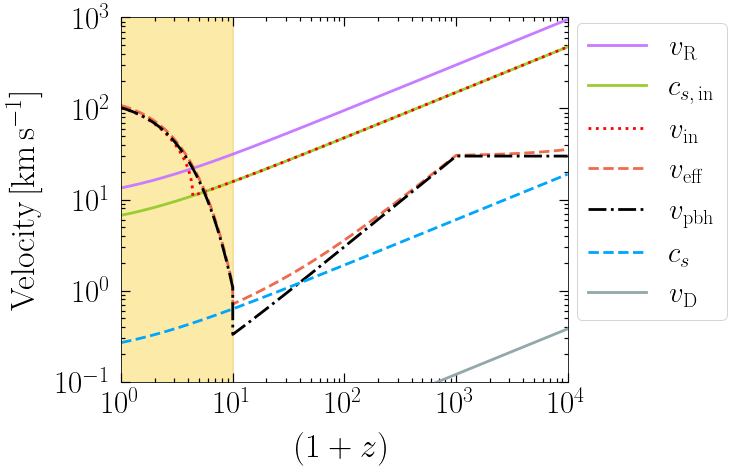

In [75]:
# Plot of v_eff, c_s(z) and v_pbh as per their definitions
# mentioned in Vivian Poulin & Pasquale D. Serpico et al. 2007 
# https://arxiv.org/abs/1707.04206. 



fig,ax = plt.subplots(1, figsize = (8, 6.7))
plt.rc('lines', linewidth = 2.8)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


z_array = np.geomspace(1, 1e4, 10000)
cs_array = np.zeros(len(z_array))
v_eff_array = np.zeros(len(z_array))
v_pbh_array = np.zeros(len(z_array))
cs_in_array = np.zeros(len(z_array))
v_eff_in_array = np.zeros(len(z_array))
v_in_array = np.zeros(len(z_array))
v_R_array = np.zeros(len(z_array))
v_D_array = np.zeros(len(z_array))


for i, z in enumerate(z_array):
    cs_array[i] = c_s(z) * (pc/yr) * 1e-3 
    v_eff_array[i] = v_eff(z) * (pc/yr) * 1e-3 
    v_pbh_array[i] = v_pbh(z) * (pc/yr) * 1e-3 
    v_eff_in_array[i] = v_eff_in(z) * (pc/yr) * 1e-3 
    cs_in_array[i] = c_s_in(z) * (pc/yr) * 1e-3
    v_in_array[i] = v_in(z) * (pc/yr) * 1e-3
    v_R_array[i] = v_R(z) * (pc/yr) * 1e-3
    v_D_array[i] = v_D(z) * (pc/yr) * 1e-3

    
#ax.loglog(z_array, v_eff_array, '#ee6c4d') 
#ax.loglog(z_array, v_pbh_array, 'k', ls = '-.') 

#ax.loglog(z_array, cs_array, '#00a6fb', ls = '--')


ax.loglog(z_array, v_R_array, '#c77dff', ls = '-')
#ax.loglog(z_array, v_eff_in_array, '#3a86ff')

ax.loglog(z_array, cs_in_array, '#9acd32')
ax.loglog(z_array, v_in_array, 'r', ls = ':')

ax.loglog(z_array, v_eff_array, '#ee6c4d', ls = '--')
ax.loglog(z_array, v_pbh_array, 'k', ls = '-.')




ax.loglog(z_array, cs_array, '#00a6fb', ls = '--')
ax.loglog(z_array, v_D_array, '#93a8ac', ls = '-')


plt.axvline(x = 10, color = '#6E705E', linewidth = 0.1)
plt.axvline(x = 1, color = '#6E705E', linewidth = 0.1)
plt.axvspan(1, 10, color='#FBDD70', alpha=0.6)


ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)


plt.ylim(0.1, 1e3)
plt.xlim(1, 1e4)

plt.legend([r'$v_\mathrm{R}$', 
             '$c_{s,\, \mathrm{in}} $','$v_{\mathrm{in}}$', '$v_\mathrm{eff}$', r'$v_\mathrm{pbh} $',
         '$c_{s}$' ,'$v_\mathrm{D}$'],
           title_fontsize = 12, loc = (1.02, 0.17), prop = {"size":29})



plt.ylabel(r"Velocity$\, \mathrm{[km \,s^{-1}}]$ ", fontsize = 34, labelpad = 13)
plt.xlabel(r"$\left(1+z\right)$", fontsize = 34, labelpad = 13)
plt.xticks(fontsize = 31)
plt.yticks(fontsize = 31)
plt.savefig('PR_velocities_nonlinear.pdf', bbox_inches = 'tight')
plt.show()

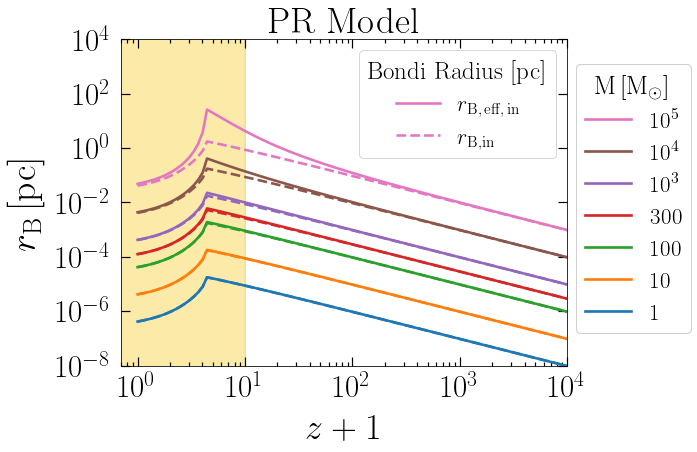

In [76]:
# Calculation of the effective Bondi Radius due to the presence of DM halo
# around the PBH.

colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (8, 6))
plt.rc('lines', linewidth = 2.6)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_arr = np.geomspace(1, 1e4, 100)


r_B_in_arr = np.zeros(len(z_arr))
r_B_eff_in_arr = np.zeros(len(z_arr))



for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for j, z in enumerate(z_arr):
        r_B_in_arr[j] = r_B_in(z, m)
        r_B_eff_in_arr[j] = r_B_eff_in(z, m)
    ax.loglog(z_arr, r_B_eff_in_arr, color = color)
    ax.loglog(z_arr, r_B_in_arr, color = color, ls = '--')
    

plt.axvline(x = 10, color = '#6E705E', linewidth = 0.1)
plt.axvline(x = 0.7, color = '#6E705E', linewidth = 0.1)
plt.axvspan(0.7, 10, color='#FBDD70', alpha=0.6)



ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], ["$r_\mathrm{B, \,eff,\,in}$", "$r_\mathrm{B, in}$"], title = 'Bondi Radius $ \mathrm{[pc]}$',
        title_fontsize = 25, loc = 'upper right', prop = {"size":22})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 26, loc = (1.02, 0.1), prop = {"size":23})
ax.add_artist(legend1)
ax.add_artist(legend2)


plt.xlabel('$z+1$', fontsize = 36, labelpad = 10)
plt.ylabel(r"$r_\mathrm{B}\, \mathrm{[pc]}$ ", fontsize = 38, labelpad = 11)
plt.xticks(fontsize = 31)
plt.yticks(fontsize = 31)

plt.ylim(1e-8, 1e4)
plt.xlim(0.7, 1e4)

# $\,\rho_{h}(r) \propto r^{-9/4}$
plt.title(r'PR Model', fontsize = 37, pad = 6)
plt.savefig('r_B_eff_PR_nonlinear.pdf', bbox_inches = 'tight')
plt.show()

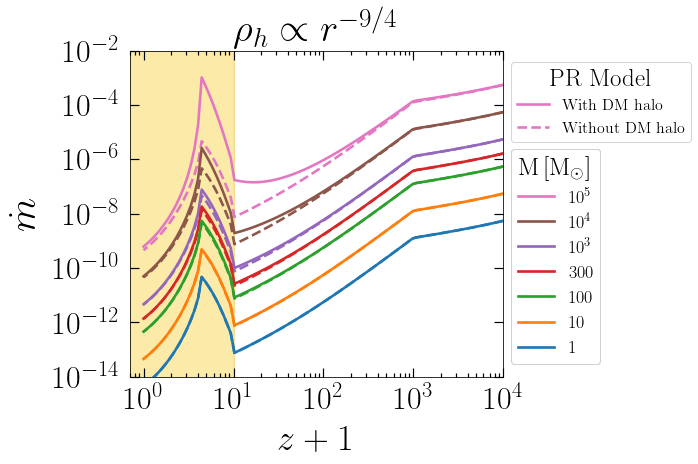

In [77]:
# Plots of m_dot in PR model with and without the presence of
# DM halos. The value of m_dot in PR Model is independent of
# the value of electron frcation, x_e.


colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 2.6)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_halo_PR_arr = np.zeros(len(z_array))
m_dot_pbh_PR_arr = np.zeros(len(z_array))




for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_halo_PR_arr[i] = m_dot_halo_PR(z, m)
        m_dot_pbh_PR_arr[i] = m_dot_pbh_PR(z, m)
    
    
    plt.loglog(z_array, m_dot_halo_PR_arr, color = color)
    plt.loglog(z_array, m_dot_pbh_PR_arr, color = color, ls = '--')
    

    
   
    
plt.axvline(x = 10, color = '#6E705E', linewidth = 0.1)
plt.axvline(x = 0.7, color = '#6E705E', linewidth = 0.1)
plt.axvspan(0.7, 10, color='#FBDD70', alpha=0.6)




plt.xlabel('$z+1$',  fontsize = 36, labelpad = 10)
plt.ylabel(' $\dot m $', fontsize = 40, labelpad = 10)
plt.xticks(fontsize = 32)
plt.yticks(fontsize = 32)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "With DM halo", "Without DM halo"], title = 'PR Model',
        title_fontsize = 25, loc = (1.02, 0.72), prop = {"size":16})
legend2 = plt.legend([lines[i] for i in [0, 2, 4, 6, 8, 10, 12]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 25, loc = (1.02, 0.04), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)



plt.ylim(1e-14, 0.01)
plt.xlim(0.7, 1e4)

plt.title(r'$\rho_{h} \propto r^{-9/4}$', fontsize = 39, pad = 9)
plt.savefig('m_dot_PR_nonlinear.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# M_f vs M_i in PR Model for PBHs with and without DM halos.
# The value of m_dot in PR Model is independent of
# the value of electron frcation, x_e.



colors = ['#a06cd5' , '#a47148', '#67bf77' ]
fig,ax = plt.subplots(1, figsize = (19, 9.5))
plt.rc('lines', linewidth = 3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')


mi_arr = np.geomspace(1, 1e5, 100)
mf_arr_pbh_PR = np.zeros(len(mi_arr))
mf_arr_halo_PR = np.zeros(len(mi_arr))



N = 10

z_cut_arr = np.array([7, 10, 15])
for i, (z_cut, color) in enumerate(zip(z_cut_arr, colors)):
    for j, m in enumerate(mi_arr):
        f_Hor = 0.2
        z_1i = z_pbh_Ricotti(m, f_Hor)
        y_1i = m
        z_cut_off1 = z_eq
        t1 = np.geomspace(z_1i, z_cut_off1, N)
        sol1_PR  = solve_ivp(M_dot_pbh_PR_by_dz, t_span = [t1[0], t1[-1]], y0 = [y_1i],  method = 'DOP853',  t_eval = t1)
        sol1_PR_halo  = solve_ivp(M_dot_halo_PR_by_dz, t_span = [t1[0], t1[-1]], y0 = [y_1i],  method = 'DOP853',  t_eval = t1)
        t1 = sol1_PR.t
        y1_PR = sol1_PR.y[0]
        y1_PR_halo = sol1_PR_halo.y[0]

        
        z_2i = z_cut_off1
        y_2i_PR  = y1_PR[-1]
        y_2i_PR_halo  = y1_PR_halo[-1]
        z_cut_off2 = z_rec
        t2 = np.geomspace(z_2i, z_cut_off2, N)
        sol2_PR  =  solve_ivp(M_dot_pbh_PR_by_dz, t_span = [t2[0], t2[-1]], y0 = [y_2i_PR], method = 'DOP853', t_eval = t2, first_step = 1, max_step = 10)
        sol2_PR_halo =  solve_ivp(M_dot_halo_PR_by_dz, t_span = [t2[0], t2[-1]], y0 = [y_2i_PR_halo], method = 'DOP853', t_eval = t2, first_step = 1, max_step = 10)
        t2 = sol2_PR.t
        y2_PR = sol2_PR.y[0]
        y2_PR_halo = sol2_PR_halo.y[0]



        z_3i = z_cut_off2
        y_3i_PR  = y2_PR[-1]
        y_3i_PR_halo  = y2_PR_halo[-1]
        z_cut_off3 = z_dec
        t3 = np.geomspace(z_3i, z_cut_off3, N)
        sol3_PR  = solve_ivp(M_dot_pbh_PR_by_dz, t_span = [t3[0], t3[-1]], y0 = [y_3i_PR], method = 'DOP853', t_eval = t3, first_step = 1, max_step = 10)
        sol3_PR_halo  = solve_ivp(M_dot_halo_PR_by_dz, t_span = [t3[0], t3[-1]], y0 = [y_3i_PR_halo], method = 'DOP853', t_eval = t3, first_step = 1, max_step = 10)
        t3 = sol3_PR.t
        y3_PR = sol3_PR.y[0]
        y3_PR_halo = sol3_PR_halo.y[0]

        
        
        z_4i = z_cut_off3
        y_4i_PR  = y3_PR[-1]
        y_4i_PR_halo  = y3_PR_halo[-1]
        z_cut_off4 = z_cut
        t4 = np.geomspace(z_4i, z_cut_off4, N)
        sol4_PR  = solve_ivp(M_dot_pbh_PR_by_dz, t_span = [t4[0], t4[-1]], y0 = [y_4i_PR], method = 'DOP853', t_eval = t4, first_step = 1, max_step = 10)
        sol4_PR_halo  = solve_ivp(M_dot_halo_PR_by_dz, t_span = [t4[0], t4[-1]], y0 = [y_4i_PR_halo], method = 'DOP853', t_eval = t4, first_step = 1, max_step = 10)
        t4 = sol4_PR.t
        y4_PR = sol4_PR.y[0]
        y4_PR_halo = sol4_PR_halo.y[0]
        
        
        
        mf_arr_pbh_PR[j]  = y4_PR[-1]
        mf_arr_halo_PR[j]  = y4_PR_halo[-1]
    
    ax.loglog(mi_arr, np.divide(mf_arr_halo_PR, mi_arr), color = color) 
    ax.loglog(mi_arr, np.divide(mf_arr_pbh_PR, mi_arr), color = color, ls = ':') 
    
    
    
    
    
ax.tick_params(axis ='x', pad = 10.9)
ax.tick_params(axis ='y', pad = 10.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], ["With DM halo", "Without DM halos "], title = 'PR Model',
        title_fontsize = 44, loc = 'upper left', prop = {"size":33})
legend2 = plt.legend([lines[i] for i in [0, 2, 4]], ['$7$', r'$10$', 
           r'$15$'], title = '$z_\mathrm{cut-off} $',
           title_fontsize = 46, loc = (0.03, 0.2), prop = {"size":36})
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.tick_params(axis = 'y', which = 'minor', labelsize = 26)

#plt.xlim(1, 500)
#plt.ylim(1, 1.00003)

plt.xticks(fontsize = 49)
plt.yticks(fontsize = 49)
plt.xlabel('$\mathrm{M}_{i}$',fontsize = 55, labelpad = 20)
plt.ylabel(r'$\mathrm{M}_{f}(z < z_\mathrm{cut-off})/\mathrm{M}_{i} $',fontsize = 55, labelpad = 16)
plt.xscale('log')
plt.title(r'$\rho_{h}(r) \propto r^{-9/4}$', fontsize = 64, pad = 17)
#plt.savefig('Mf_PR.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# Combined plots for BHL and PR accretion Models

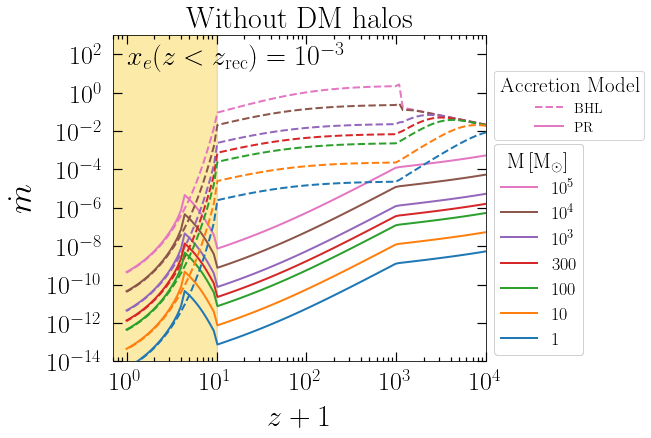

In [69]:
# Plots of m_dot in BHL with x_e = 1e-3 & PR model, without the presence of
# DM halos.


colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 2)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_pbh_BHL_arr = np.zeros(len(z_array))
m_dot_pbh_PR_arr = np.zeros(len(z_array))


e_fraction = 1e-3


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_pbh_BHL_arr[i] = m_dot_pbh_BHL(z, m)
        m_dot_pbh_PR_arr[i] = m_dot_pbh_PR(z, m)
    
    
    plt.loglog(z_array, m_dot_pbh_BHL_arr, color = color, ls = '--')
    plt.loglog(z_array, m_dot_pbh_PR_arr, color = color)

    
    
plt.axvline(x = 10, color = '#6E705E', linewidth = 0.1)
plt.axvline(x = 0.7, color = '#6E705E', linewidth = 0.1)
plt.axvspan(0.7, 10, color='#FBDD70', alpha=0.6)

plt.text(1, 30, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 28)
plt.xlabel('$z+1$',  fontsize = 30, labelpad = 10)
plt.ylabel(' $\dot m$', fontsize = 35, labelpad = 10)
plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)
ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "BHL", "PR"], title = 'Accretion Model ',
        title_fontsize = 21, loc = (1.02, 0.68), prop = {"size":14})
legend2 = plt.legend([lines[i] for i in [1, 3, 5, 7, 9, 11, 13]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 21, loc = (1.02, 0.02), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.ylim(1e-14, 1000)
plt.xlim(0.7, 1e4)

plt.title(r'Without DM halos', fontsize = 30, pad = 8)
#plt.savefig('m_dotBHLPR_xe1e-3.pdf', bbox_inches = 'tight')
plt.show()


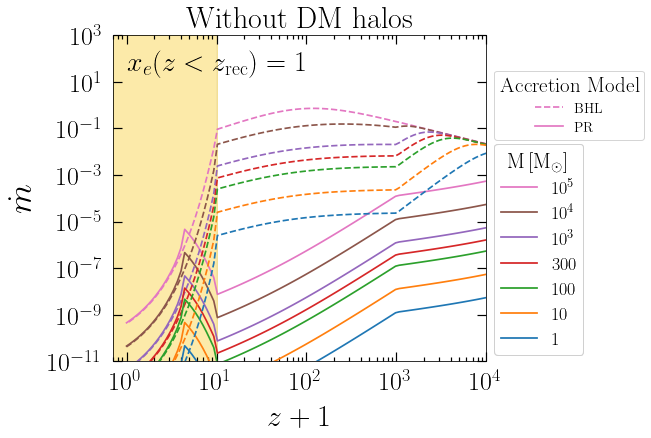

In [72]:
# Plots of m_dot in BHL with x_e = 1 & PR model, without the presence of
# DM halos.


colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 1.7)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_pbh_BHL_arr = np.zeros(len(z_array))
m_dot_pbh_PR_arr = np.zeros(len(z_array))


e_fraction = 1


for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        m_dot_pbh_BHL_arr[i] = m_dot_pbh_BHL(z, m)
        m_dot_pbh_PR_arr[i] = m_dot_pbh_PR(z, m)
    
    
    plt.loglog(z_array, m_dot_pbh_BHL_arr, color = color, ls = '--')
    plt.loglog(z_array, m_dot_pbh_PR_arr, color = color)
    
plt.axvline(x = 10, color = '#6E705E', linewidth = 0.1)
plt.axvline(x = 0.7, color = '#6E705E', linewidth = 0.1)
plt.axvspan(0.7, 10, color='#FBDD70', alpha=0.6)
    
plt.text(1, 30, '$x_{e}(z < z_\mathrm{rec}) = 1$', fontsize = 28)
plt.xlabel('$z+1$',  fontsize = 30, labelpad = 10)
plt.ylabel(' $\dot m$', fontsize = 35, labelpad = 10)
plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)
ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1]], [ "BHL", "PR"], title = 'Accretion Model ',
        title_fontsize = 21, loc = (1.02, 0.68), prop = {"size":14})
legend2 = plt.legend([lines[i] for i in [1, 3, 5, 7, 9, 11, 13]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 21, loc = (1.02, 0.02), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)
plt.ylim(1e-11, 1000)
plt.xlim(0.7, 1e4)

plt.title(r'Without DM halos', fontsize = 30, pad = 8)
#plt.savefig('m_dotBHLPR_xe1.pdf', bbox_inches = 'tight')
plt.show()

In [ ]:
# Calculation of effective Bondi radii with and without DM halos 
# in BHL and PR accretion Models.

colors = ['C6', 'C5','C4','C3','C2', 'C1', 'C0']
fig,ax = plt.subplots(1, figsize = (10, 8))
plt.rc('lines', linewidth = 2.2)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')

mi_arr = np.array([1e5, 1e4, 1000, 300, 100, 10, 1])
z_array = np.geomspace(1, 1e4, 10000)
r_B_array = np.zeros(len(z_array))
r_B_in_array = np.zeros(len(z_array))
r_B_eff_array = np.zeros(len(z_array))
r_B_eff_in_array = np.zeros(len(z_array))



for i, (m, color) in enumerate(zip(mi_arr, colors)):
    for i, z in enumerate(z_array):
        r_B_array[i] = r_B_pbh(z, m) 
        r_B_in_array[i] = r_B_in(z, m)
        r_B_eff_array[i] = r_B_eff(z, m)
        r_B_eff_in_array[i] = r_B_eff_in(z, m)
        
    ax.loglog(z_array, r_B_eff_array, color = color)
    ax.loglog(z_array, r_B_array, color = color, ls = 'dotted')
    ax.loglog(z_array, r_B_eff_in_array, color = color, ls = '--')
    ax.loglog(z_array, r_B_in_array, color = color, ls = '-.')

    
    



ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1, 2, 3]], ["$r_\mathrm{B, \,eff}$", "$r_\mathrm{B}$", "$r_\mathrm{B, \,eff, \,in}$", "$r_\mathrm{B, \, in}$"], title = 'Bondi Radius $ \mathrm{[pc]}$',
        title_fontsize = 20, loc = 'upper right', prop = {"size":19})
legend2 = plt.legend([lines[i] for i in [0, 4, 8, 12, 16, 20, 24]], ['$10^{5}$' ,  '$10^{4}$', '$10^{3}$', '$300$','$100$', '$10$','$1$']
                     , title = '$ \mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 24, loc = (1.02, 0.27), prop = {"size":18})
ax.add_artist(legend1)
ax.add_artist(legend2)




plt.ylabel(r"$r_\mathrm{B}\, \mathrm{[pc]}$ ", fontsize = 35, labelpad = 11)
plt.xlabel(r"$z + 1$", fontsize = 32, labelpad = 8)
plt.xticks(fontsize = 28)
plt.yticks(fontsize = 28)
plt.title('Bondi Radius', fontsize = 33, pad = 6)
#plt.savefig('r_B_total.pdf', bbox_inches = 'tight')
plt.show()

/tmp/ipykernel_31390/2323909767.py:137: RuntimeWarning: invalid value encountered in double_scalars
  return ((a(z, m) * (x**p)) - b(z, m)*x + c(z, m))


RuntimeError: Failed to converge after 80 iterations, value is nan.

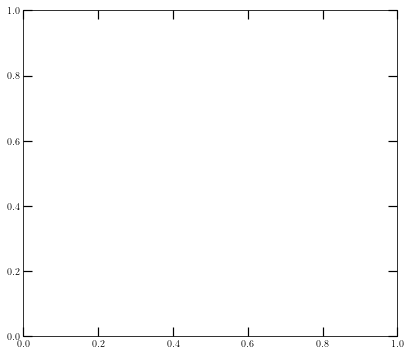

In [74]:
# Plots of m_dot in BHL model with and without the presence of
# DM halos for x_e = 1.

colors_1 = ['#ff3a3a', '#ff7b7b', '#FFB9B9']
colors_2 = ['#3188C9', '#6CABDB', '#A9CEEA']

fig,ax = plt.subplots(1, figsize = (6.7, 6))
plt.rc('lines', linewidth = 2.3)
plt.rcParams['font.family'] = 'serif'
plt.tick_params(axis = 'both', right=True, top=True, which = 'minor', width= 1.2, length = 4, direction = 'in')
plt.tick_params(axis = 'both', right=True, top=True, which = 'major', width= 1.2, length = 9, direction = 'in')



mi_arr = np.array([1e5, 1000,   1])
z_array = np.geomspace(1e4, 1, 100)
m_dot_pbh_arr = np.zeros(len(z_array))
m_dot_halo_arr = np.zeros(len(z_array))
m_dot_pbh_PR_arr = np.zeros(len(z_array))
m_dot_halo_PR_arr = np.zeros(len(z_array))


e_fraction = 1e-3
 

for i, (m, color1, color2) in enumerate(zip(mi_arr, colors_1, colors_2)):
    for i, z in enumerate(z_array):
        m_dot_pbh_arr[i] = m_dot_pbh_BHL(z, m)
        m_dot_halo_arr[i] = m_dot_halo_BHL(z, m)
        m_dot_halo_PR_arr[i] = m_dot_halo_PR(z, m)
        m_dot_pbh_PR_arr[i] = m_dot_pbh_PR(z, m)
    
    ax.loglog(z_array, m_dot_halo_arr, color = color1)
    ax.loglog(z_array, m_dot_pbh_arr, color = color1, ls = '--')
    
    ax.loglog(z_array, m_dot_halo_PR_arr, color = color2)
    ax.loglog(z_array, m_dot_pbh_PR_arr, color = color2, ls = '--')

       

#plt.text(2, 300, '$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 26)
plt.xlabel('$z+1$',  fontsize = 35, labelpad = 10)
plt.ylabel(' $\dot m $', fontsize = 38, labelpad = 10)
plt.xticks(fontsize = 29)
plt.yticks(fontsize = 29)

ax.tick_params(axis='x', pad = 9.9)
ax.tick_params(axis='y', pad = 9.9)
lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in [0, 1, 2, 3]], ["BHL$_\mathrm{with \, halo}$", r"BHL", "PR$_\mathrm{with \, halo}$", "PR"], title = 'Accretion Model',
        title_fontsize = 27, loc =  (1.02, 0.5), prop = {"size":19})
legend2 = plt.legend([lines[i] for i in [0, 4, 8]], ['$10^{5}$', '$10^{3}$', '$1$'], title = '$\mathrm{M\, [M_{\odot}]}$',
           title_fontsize = 27, loc = (1.02, 0.05), prop = {"size":21})

ax.add_artist(legend1)
ax.add_artist(legend2)


plt.ylim(5e-10, 100)

plt.title(r'$x_{e}(z < z_\mathrm{rec}) = 10^{-3}$', fontsize = 33, pad = 7)
#plt.savefig('m_dot_BHLPR_comp_xe1e-3.pdf', bbox_inches = 'tight')
plt.show()